# Librerías que vamos a utilizar

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import pmdarima as pm

## Lectura del archivo de datos en un dataframe

In [170]:
# Ruta al fichero (cámbiala según tu necesidad)
file_path = './laguna_datos_horarios_rellenos.csv'

# Cargar el fichero en un DataFrame
df = pd.read_csv(file_path)

#Añadimos temperatura media

#df['Tmedia'] = (df['Tmax'] + df['Tmin'])/2

#Mostramos cuantas filas y columnas se han cargado en total
print(f"Se han cargado {df.shape[0]} filas y {df.shape[1]} columnas")
# Mostrar las primeras filas para verificar
print(df.head())

Se han cargado 2113 filas y 4 columnas
             fecha  temperatura   ambiente  nivel
0  17/06/2023 0:00       31.500  22.000000   51.0
1  17/06/2023 1:00       31.470  21.780000   51.0
2  17/06/2023 2:00       31.235  21.201000   47.8
3  17/06/2023 3:00       31.295  22.439250   52.0
4  17/06/2023 4:00       31.375  23.058375   50.0


## Visualización de la Serie Temporal

***1. Grafica los datos para observar las fluctuaciones de temperatura a lo largo del tiempo.*** 

***2. Identifica patrones visuales como tendencia (por ejemplo, aumento gradual de la temperatura a lo largo de los años) y estacionalidad (variaciones cíclicas relacionadas con las estaciones del año).***


/tmp/ipykernel_497243/583127188.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['fecha'] = pd.to_datetime(df['fecha'])


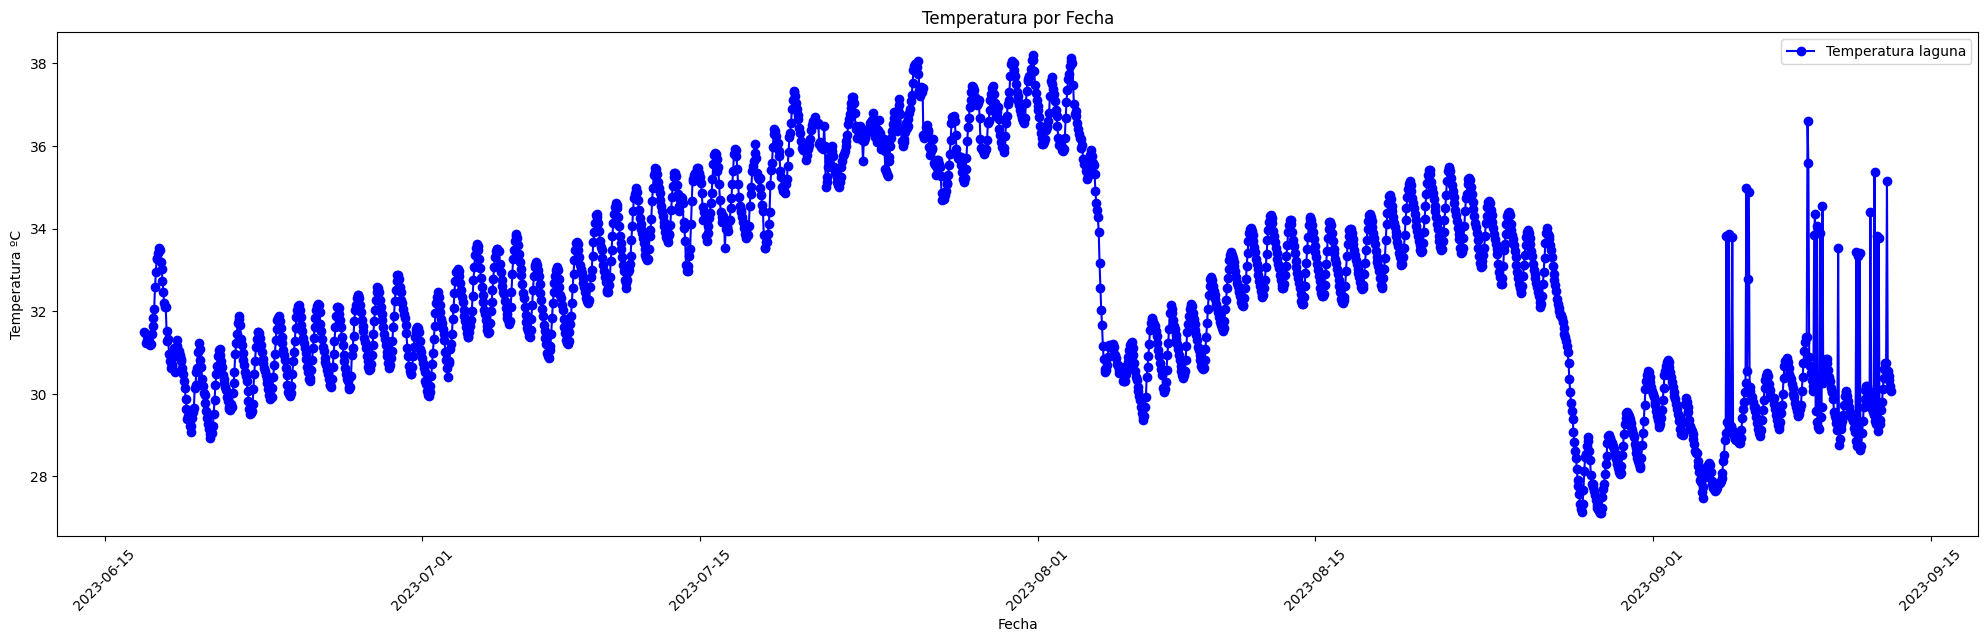

In [171]:
# Asegúrate de que la columna "fecha" esté en formato de fecha
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')

# Crear el gráfico
plt.figure(figsize=(20, 6))  # Ajusta el tamaño según lo desees
plt.plot(df['fecha'], df['temperatura'], label='Temperatura laguna', color='blue', marker='o')
plt.title('Temperatura por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Temperatura ºC')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para mejor visualización si es necesario
plt.show()

## Division de datos

In [172]:
train = df['temperatura'].iloc[:-20]
test = df['temperatura'].tail(20)

## Aplicación del Modelo Autorregresivo (AR)

In [173]:
# Aplicamos el modelo AR
modelo_ar = AutoReg(train, lags=1)  # Puedes cambiar el número de lags si es necesario
resultados_ar = modelo_ar.fit()
print(resultados_ar.summary())


                            AutoReg Model Results                             
Dep. Variable:            temperatura   No. Observations:                 2093
Model:                     AutoReg(1)   Log Likelihood               -1874.992
Method:               Conditional MLE   S.D. of innovations              0.593
Date:                Mon, 30 Oct 2023   AIC                           3755.984
Time:                        14:01:35   BIC                           3772.922
Sample:                             1   HQIC                          3762.189
                                 2093                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9150      0.169      5.416      0.000       0.584       1.246
temperatura.L1     0.9721      0.005    188.791      0.000       0.962       0.982
                                    

**Interpretación:**
   
Una vez que hayas ejecutado el modelo, obtendrás un resumen de los resultados. En el resumen, el coeficiente del término `L1.columna_temp` te dará la autocorrelación de primer orden (si utilizaste `lags=1`). Un valor cercano a 1 indica una fuerte autocorrelación positiva, mientras que un valor cercano a -1 indica una fuerte autocorrelación negativa. El valor `P>|z|` te dirá si el coeficiente es estadísticamente significativo.

Ten en cuenta que he asumido que estás usando un retraso (lag) de 1 para el modelo AR. Si quieres usar más retrasos, simplemente cambia el valor en el parámetro `lags` en la función `AutoReg`.

## Evaluación (AR) 
***Juega con los lags anteriores para ver si hay algún cambio***

In [174]:
pred = resultados_ar.predict(start=len(train), end=len(train)+19)

mse = mean_squared_error(test, pred)
r2 = r2_score(test, pred)

print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Coeficiente de Determinación R^2: {r2:.2f}")

Error Cuadrático Medio (MSE): 19.61
Coeficiente de Determinación R^2: -6.46


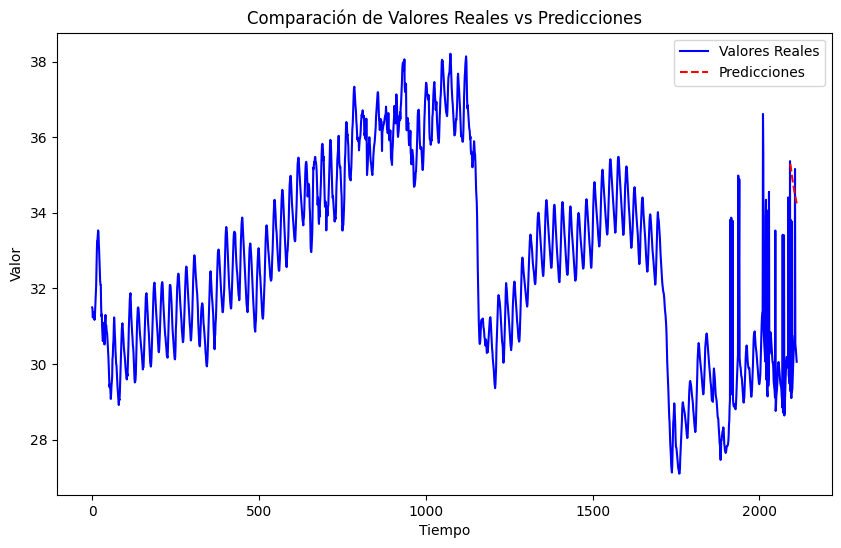

In [175]:
# Tamaño de la figura
plt.figure(figsize=(10,6))

# Graficar los valores reales (test)
full_data = np.concatenate([train, test])

plt.plot(full_data, label='Valores Reales', color='blue')

# Graficar las predicciones (pred)
plt.plot(pred, label='Predicciones', color='red', linestyle='--')

# Título y etiquetas
plt.title('Comparación de Valores Reales vs Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()

# Mostrar la gráfica
plt.show()


In [176]:
## Aplicación del modelo ARIMA


In [177]:
modelARIMA = ARIMA(train, order=(5,1,4))
resultados_arima = modelARIMA.fit()

/home/chema/PythonProjects/SII/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [178]:
predARIMA = resultados_arima.predict(start=len(train), end=len(train)+19, dynamic=False)

## Evaluación (ARIMA) 

In [179]:
mse = mean_squared_error(test, predARIMA)
r2 = r2_score(test, predARIMA)

print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Coeficiente de Determinación R^2: {r2:.2f}")

Error Cuadrático Medio (MSE): 14.89
Coeficiente de Determinación R^2: -4.67


## Visualización

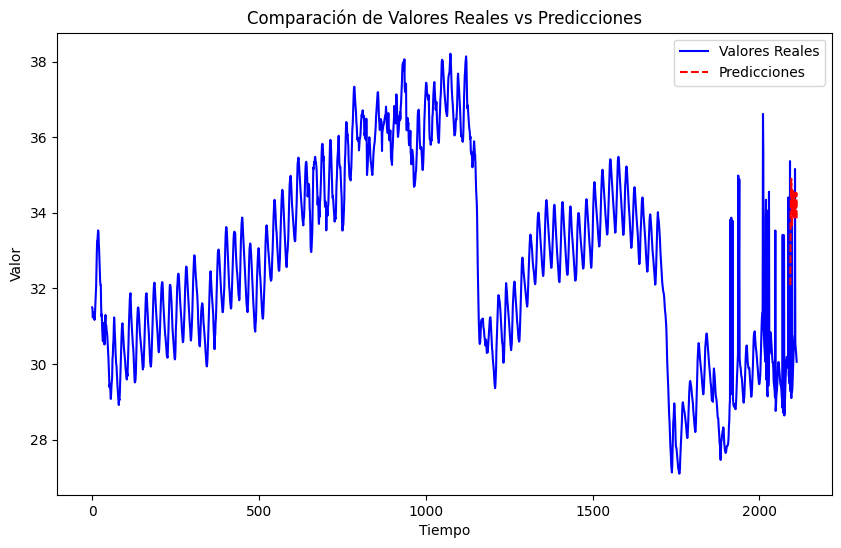

In [180]:
# Tamaño de la figura
plt.figure(figsize=(10,6))
 
plt.plot(full_data, label='Valores Reales', color='blue')

# Graficar las predicciones (pred)
plt.plot(predARIMA, label='Predicciones', color='red', linestyle='--')

# Título y etiquetas
plt.title('Comparación de Valores Reales vs Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()

# Mostrar la gráfica
plt.show()

***El método auto_arima de la biblioteca pmdarima facilita el proceso de ajustar automáticamente los mejores parámetros p, d, y q para un modelo ARIMA. Este proceso es conocido como "grid search" sobre los posibles valores de p, d, y q.***


In [166]:
stepwise_fit = pm.auto_arima(df['temperatura'], 
                             trace=True, 
                             suppress_warnings=True, 
                             seasonal=False)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3647.403, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4214.899, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3758.321, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3788.286, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4212.901, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3664.255, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3712.525, Time=0.73 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3643.120, Time=1.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3685.048, Time=0.63 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3641.824, Time=1.86 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3675.808, Time=0.82 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3645.807, Time=2.99 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3638.147, Time=1.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3651.403, Time=1.11 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept

In [167]:
print(stepwise_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2113
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -1691.614
Date:                Mon, 30 Oct 2023   AIC                           3403.229
Time:                        13:58:46   BIC                           3459.783
Sample:                             0   HQIC                          3423.937
                               - 2113                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1255      0.029     -4.284      0.000      -0.183      -0.068
ar.L2          1.4124      0.027     53.020      0.000       1.360       1.465
ar.L3          0.4830      0.023     21.179      0.0